<a href="https://colab.research.google.com/github/vinhngx/tensorrt/blob/vinhn-tf20-notebook/tftrt/examples/image-classification/Colab-TF20-TF-TRT-inference-from-Keras-saved-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# TF-TRT Inference from Keras Model with TensorFlow 2.0

In this notebook, we demonstrate the process to create a TF-TRT optimized model from a Keras saved model.

## Requirement
We first install several helper Ubuntu and Python libraries, then import the required libraries.

### TensorFlow 2.x

In [5]:
!pip install pillow matplotlib
!pip install tf-nightly-gpu

     |████████████████████████████████| 396.0MB 60kB/s 
     |████████████████████████████████| 450kB 46.6MB/s 
     |████████████████████████████████| 3.8MB 44.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d061cf983658fa53b695854fea5d48b46140dadcd46a822920b78bb84ec6cd77
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.2
    Uninstalling gast-0.3.2:
      Successfully uninstalled gast-0.3.2


### TensorRT Runtime

In [2]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer5

(Reading database ... 131186 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) over (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Ign:8 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Ign:10 https://devel

--2019-10-07 05:00:15--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 192.229.221.58, 2606:2800:233:ef6:15dd:1ece:1d50:1e1
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|192.229.221.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.1’

     0K ..                                                    100%  142M=0s

2019-10-07 05:00:15 (142 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.1’ saved [2926/2926]

W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print("Tensorflow version: ", tf.version.VERSION)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

Tensorflow version:  2.1.0-dev20191006
TensorRT version: 
ii  libnvinfer5                             5.1.5-1+cuda10.1                                  amd64        TensorRT runtime libraries


### GPU
This demo will work on any NVIDIA GPU, though for improved FP16 and INT8 inference, a Volta, Turing or newer generation GPU is required.

In [5]:
!nvidia-smi

Mon Oct  7 05:02:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    69W / 149W |     69MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: None


## Data
We download several images from the Internet.

In [6]:
!mkdir ./data
!wget  -O ./data/img1.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"

--2019-10-07 05:03:27--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 13.224.217.12, 13.224.217.140, 13.224.217.119, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|13.224.217.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img1.JPG’

./data/img1.JPG     100%[===================>]  23.55K  --.-KB/s    in 0.08s   

2019-10-07 05:03:28 (308 KB/s) - ‘./data/img1.JPG’ saved [24112/24112]



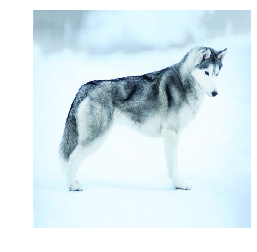

In [8]:
from tensorflow.keras.preprocessing import image

img_path = './data/img1.JPG'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img);
plt.axis('off');

## Model

We download a ResNet-50 saved Keras model.

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = './data/img1.JPG'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [('n02110185', 'Siberian_husky', 0.55662125), ('n02109961', 'Eskimo_dog', 0.4173722), ('n02110063', 'malamute', 0.020951565)]

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02110185', 'Siberian_husky', 0.5566208), ('n02109961', 'Eskimo_dog', 0.4173726), ('n02110063', 'malamute', 0.020951588)]


TF-TRT work with TensorFlow saved model, therefore, we re-export the Keras model as a TF saved model.

In [0]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model') 

In [11]:
!saved_model_cli show --all --dir resnet50_saved_model


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['probs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function Name: '__call__'


### Inference with naitive TF2.0 saved model

In [12]:
!ls resnet50_saved_model

assets	saved_model.pb	variables


In [0]:
model = tf.keras.models.load_model('resnet50_saved_model')


In [14]:
model

In [15]:
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02110185', 'Siberian_husky', 0.5566208), ('n02109961', 'Eskimo_dog', 0.4173726), ('n02110063', 'malamute', 0.020951588)]


### TF-TRT FP32 model

We first convert the TF naitive FP32 model to a TF-TRT FP32 model.

In [0]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='resnet50_saved_model')
converter.convert()
#optionally build TRT engines before deployment
#convert.build(input_fn=my_input_fn)
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP32')


In [17]:
!ls resnet50_saved_model_TFTRT_FP32

assets	saved_model.pb	variables


In [18]:
!saved_model_cli show --all --dir resnet50_saved_model_TFTRT_FP32


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['probs'] tensor_info:
        dtype: DT_FLOAT
        shape: unknown_rank
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function Name: '__call__'
    Op

In [0]:
model_TFTRT_FP32 = tf.keras.models.load_model('resnet50_saved_model_TFTRT_FP32')


In [20]:
model_TFTRT_FP32

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f01eb49e0b8>

In [21]:
preds = model_TFTRT_FP32.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

AttributeError: ignored

### TF-TRT FP16 model
We first convert the TF FP32 saved model to TF-TRT FP16 model.

In [0]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP16, 
                                                                       max_batch_size=1, 
                                                                       max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)
converter.convert()
#optionally build TRT engines before deployment
#convert.build(input_fn=my_input_fn)
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP16')


In [23]:
model_TFTRT_FP16 = tf.keras.models.load_model('resnet50_saved_model_TFTRT_FP16')

preds = model_TFTRT_FP16.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

AttributeError: ignored

### TF-TRT INT8 model

In [0]:
def calibration_input_fn(): 
    features = np.random.rand(64,224,224,3)
    labels = np.random.randint(0, 1000, (64,1))
    return features, labels
    

In [0]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.INT8, 
                                                                       max_batch_size=1, 
                                                                       max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)
converter.convert(calibration_input_fn =calibration_input_fn )
#optionally build TRT engines before deployment
#convert.build(input_fn=my_input_fn)
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_INT8')


## Conclusion
In this notebook, we have demonstrated the process of creating TF-TRT inference model from an original Keras FP32 model. 
